# Mission 03 Test
This utilizes the result of the new graph building instead of the builtin nngraph.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pygsp import graphs, filters, plotting, reduction
import pandas

%load_ext autoreload
%autoreload 2
%matplotlib widget

plotting.BACKEND = 'matplotlib'
plt.rcParams['figure.figsize'] = (10, 5)

#COLOR = 'white'
#plt.rcParams['text.color'] = COLOR
#plt.rcParams['axes.labelcolor'] = COLOR
#plt.rcParams['xtick.color'] = COLOR
#plt.rcParams['ytick.color'] = COLOR


## Read the input data and the signals

In [2]:
dataset_path = '/home/berlukas/Documents/workspace/fgsp_ws/src/fgsp/data/mission_03/adj_test/'
graph_file = dataset_path + 'cdpgo_graph.csv'
signal_file = dataset_path + 'cdpgo_signal.csv'
adj_file = dataset_path + 'cdpgo_adj.csv'

graph_labels = ['ts', 'qw', 'qx', 'qy', 'qz', 'x', 'y', 'z']
signal_labels = ['residual']
graph_df = pandas.read_csv(graph_file, names=graph_labels, delimiter=',', header=0)
signal_df = pandas.read_csv(signal_file, names=signal_labels, delimiter=',', header=None)
#adj_df = pandas.read_csv(adj_file, delimiter=' ', header=None)
adj = np.genfromtxt(adj_file, dtype=float)


print(f'\nRead {graph_df.size} (graph) and {signal_df.size} (signal)  entries.')
print(f'\nShape of the adjacency matrix {adj.shape}')


Read 8664 (graph) and 1083 (signal)  entries.

Shape of the adjacency matrix (1083, 1083)


In [4]:
dataset_path = '/home/berlukas/Documents/workspace/fgsp_ws/src/fgsp/data/mission_03/'
loam_file = dataset_path + 'loam_header_less.csv'
rovio_file = dataset_path + 'rovio_header_less.csv'
opt_file = dataset_path + 'opt_header_less.csv'

labels = ['ts', 'vertex-id', 'mission_id', 'p_G_Ix', 'p_G_Iy', 'p_G_Iz', 'q_G_Iw', 'q_G_Ix', 'q_G_Iy', 'q_G_Iz', 'p_M_Ix', 'p_M_Iy', 'p_M_Iz', 'q_M_Iw', 'q_M_Ix', 'q_M_Iy', 'q_M_Iz', 'v_Mx', 'v_My', 'v_Mz', 'bgx', 'bgy', 'bgz', 'bax', 'bay', 'baz']
loam_df = pandas.read_csv(loam_file, names=labels, delimiter=',', header=None)
rovio_df = pandas.read_csv(rovio_file, names=labels, delimiter=',', header=None)
opt_df = pandas.read_csv(opt_file, names=labels, delimiter=',', header=None)

print(f'\nRead {loam_df.size} (loam), {rovio_df.size} (rovio) and {opt_df.size} (opt)  entries.')


Read 27690 (loam), 27768 (rovio) and 12220 (opt)  entries.


## Synchronization of the Trajectories

Based on the timestampe we synchronize each mission to the exported server trajectory

In [9]:
loam_ts = loam_df[['ts']].to_numpy()
rovio_ts = rovio_df[['ts']].to_numpy()
opt_ts = opt_df[['ts']].to_numpy()
server_ts = graph_df[['ts']].to_numpy()

server_size = server_ts.shape[0]

print(f'Processing {server_size} optimized entries.')
loam_idx = np.zeros((server_size, 1))
rovio_idx = np.zeros((server_size, 1))
opt_idx = np.zeros((server_size, 1))

for i in range(0, server_size):
    cur_ts = server_ts[i,0]    
        
    loam_ts_diff = np.absolute(loam_ts - cur_ts)    
    cur_min_loam_index = np.where(loam_ts_diff == np.amin(loam_ts_diff))[0]    
    loam_idx[i] = cur_min_loam_index[0]
    
    rovio_ts_diff = np.absolute(rovio_ts - cur_ts)
    cur_min_rovio_index = np.where(rovio_ts_diff == np.amin(rovio_ts_diff))[0]
    rovio_idx[i] = cur_min_rovio_index[0]
    
    opt_ts_diff = np.absolute(opt_ts - cur_ts)
    cur_min_opt_index = np.where(opt_ts_diff == np.amin(opt_ts_diff))[0]
    opt_idx[i] = cur_min_opt_index[0]
    

Processing 1083 optimized entries.


## Graph generation

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8b9ad03f98>)

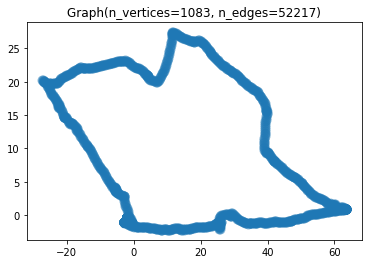

In [12]:
N = graph_df[['x', 'y']].to_numpy()
G = graphs.Graph(adj)
G.set_coordinates(N)
G.compute_fourier_basis()

G.plot()

In [22]:
loam_graph = loam_df[['p_G_Ix', 'p_G_Iy', 'p_G_Iz']].to_numpy()
rovio_graph = rovio_df[['p_G_Ix', 'p_G_Iy', 'p_G_Iz']].to_numpy()
opt_graph = opt_df[['p_G_Ix', 'p_G_Iy', 'p_G_Iz']].to_numpy()
loam_graph = loam_graph[loam_idx.astype(int),:].squeeze()
rovio_graph = rovio_graph[rovio_idx.astype(int),:].squeeze()
opt_graph = opt_graph[opt_idx.astype(int),:].squeeze()

loam_origin = loam_graph[0,:]
rovio_origin = rovio_graph[0,:]
opt_origin = opt_graph[0,:]

loam_pos_signal = (loam_graph - loam_origin).squeeze()
rovio_pos_signal = (rovio_graph - rovio_origin).squeeze()
opt_pos_signal = (opt_graph - opt_origin).squeeze()

x_loam = np.linalg.norm(loam_pos_signal, ord=2, axis=1)
x_rovio = np.linalg.norm(rovio_pos_signal, ord=2, axis=1)
x_opt = np.linalg.norm(opt_pos_signal, ord=2, axis=1)

In [23]:
x_loam_hat = G.gft(x_loam).squeeze()
x_rovio_hat = G.gft(x_rovio).squeeze()
x_opt_hat = G.gft(x_opt).squeeze()


print(f'LOAM: $x^T L x = {G.dirichlet_energy(x_loam)}$')
print(f'ROVIO: $x^T L x = {G.dirichlet_energy(x_rovio)}$')
print(f'OPT: $x^T L x = {G.dirichlet_energy(x_opt)}$')

LOAM: $x^T L x = 65923.4478334938$
ROVIO: $x^T L x = 173782.72409545208$
OPT: $x^T L x = 64109.235927337235$


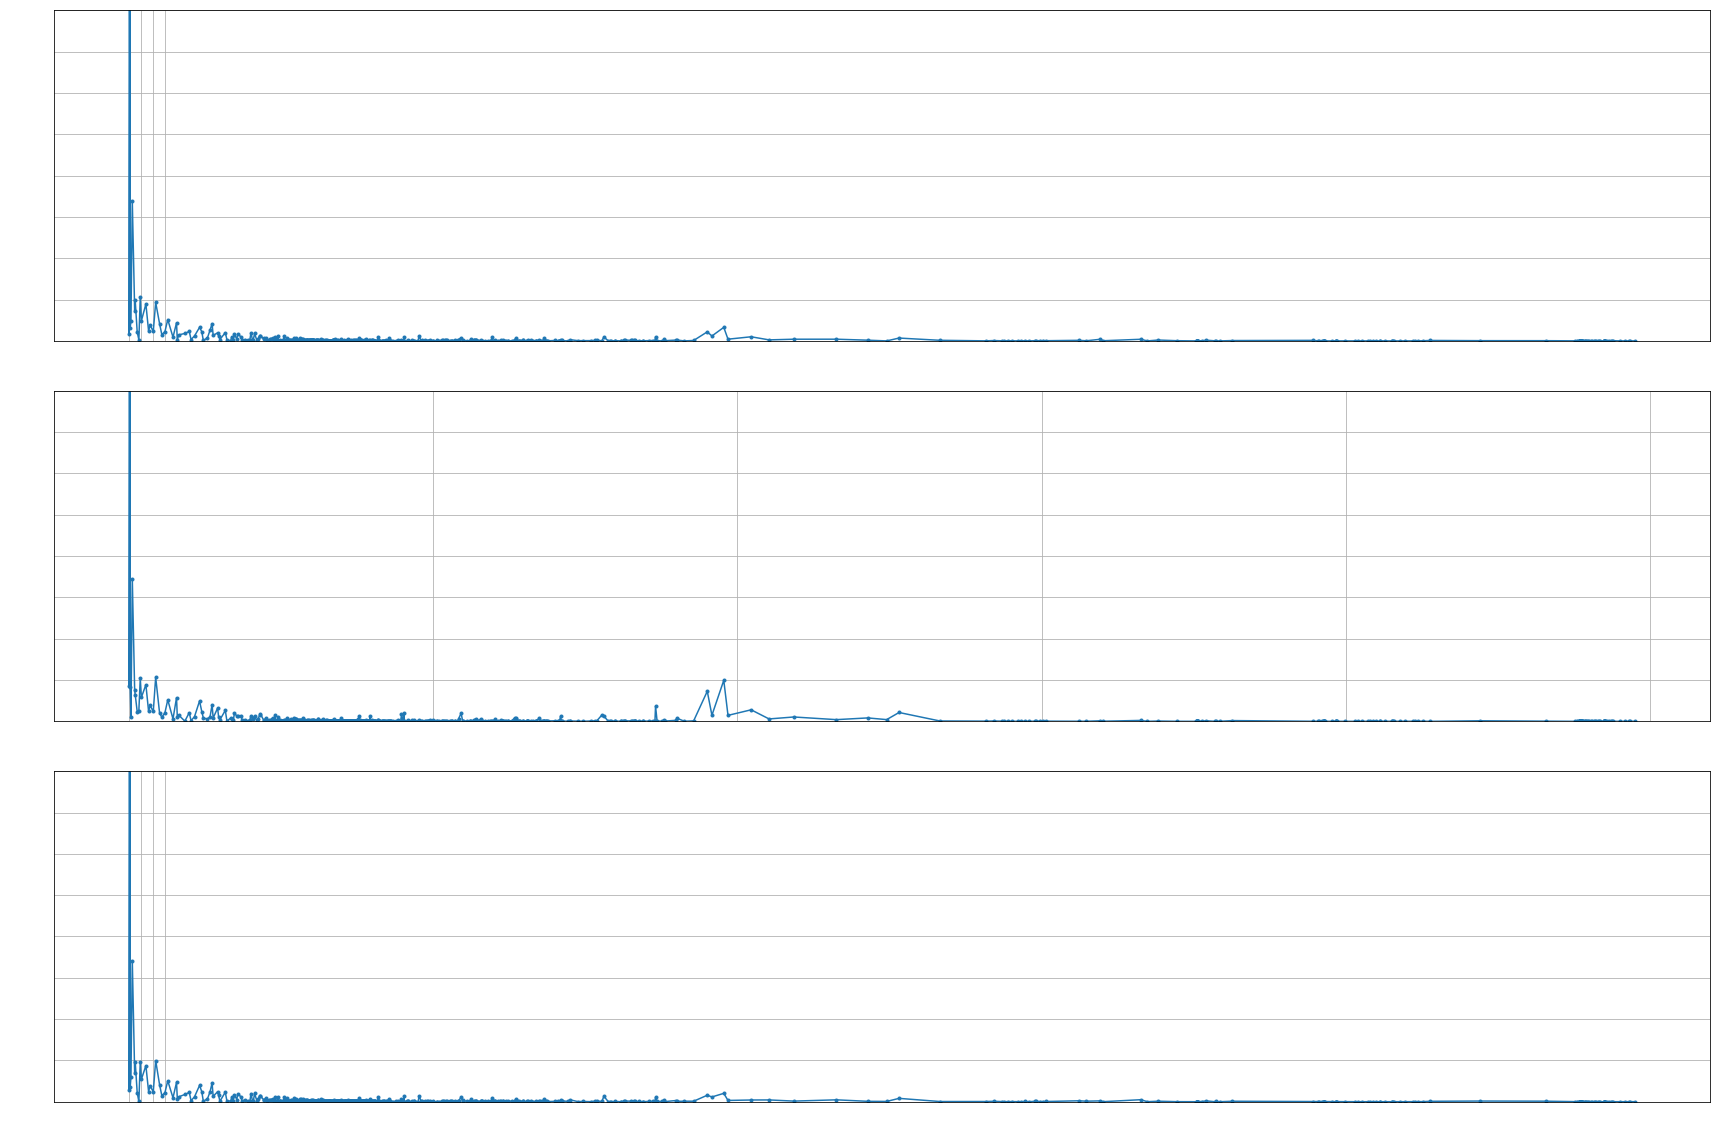

In [24]:
fig, axes = plt.subplots(3, 1, figsize=(24, 16))
fig.subplots_adjust(hspace=0.5)

axes[0].plot(G.e, np.abs(x_loam_hat), '.-')
axes[0].set_xticks(range(0, 8, 2))
axes[0].set_xlabel(r'graph frequency $\lambda$', color="white")
axes[0].set_ylim(-0.05, 200)
axes[0].set_ylabel(r'frequency content $\hat{x}(\lambda)$', color="white")
axes[0].tick_params(axis='x', colors='white')
axes[0].tick_params(axis='y', colors='white')
axes[0].grid()

axes[1].plot(G.e, np.abs(x_rovio_hat), '.-')
#axes[1].set_xticks(range(0, 8, 2))
axes[1].set_xlabel(r'graph frequency $\lambda$', color="white")
axes[1].set_ylim(-0.05, 200)
axes[1].set_ylabel(r'frequency content $\hat{x}(\lambda)$', color="white")
axes[1].tick_params(axis='x', colors='white')
axes[1].tick_params(axis='y', colors='white')
axes[1].grid()

axes[2].plot(G.e, np.abs(x_opt_hat), '.-')
axes[2].set_xticks(range(0, 8, 2))
axes[2].set_xlabel(r'graph frequency $\lambda$', color="white")
axes[2].set_ylim(-0.05, 200)
axes[2].set_ylabel(r'frequency content $\hat{x}(\lambda)$', color="white")
axes[2].tick_params(axis='x', colors='white')
axes[2].tick_params(axis='y', colors='white')
axes[2].grid()

fig.tight_layout()

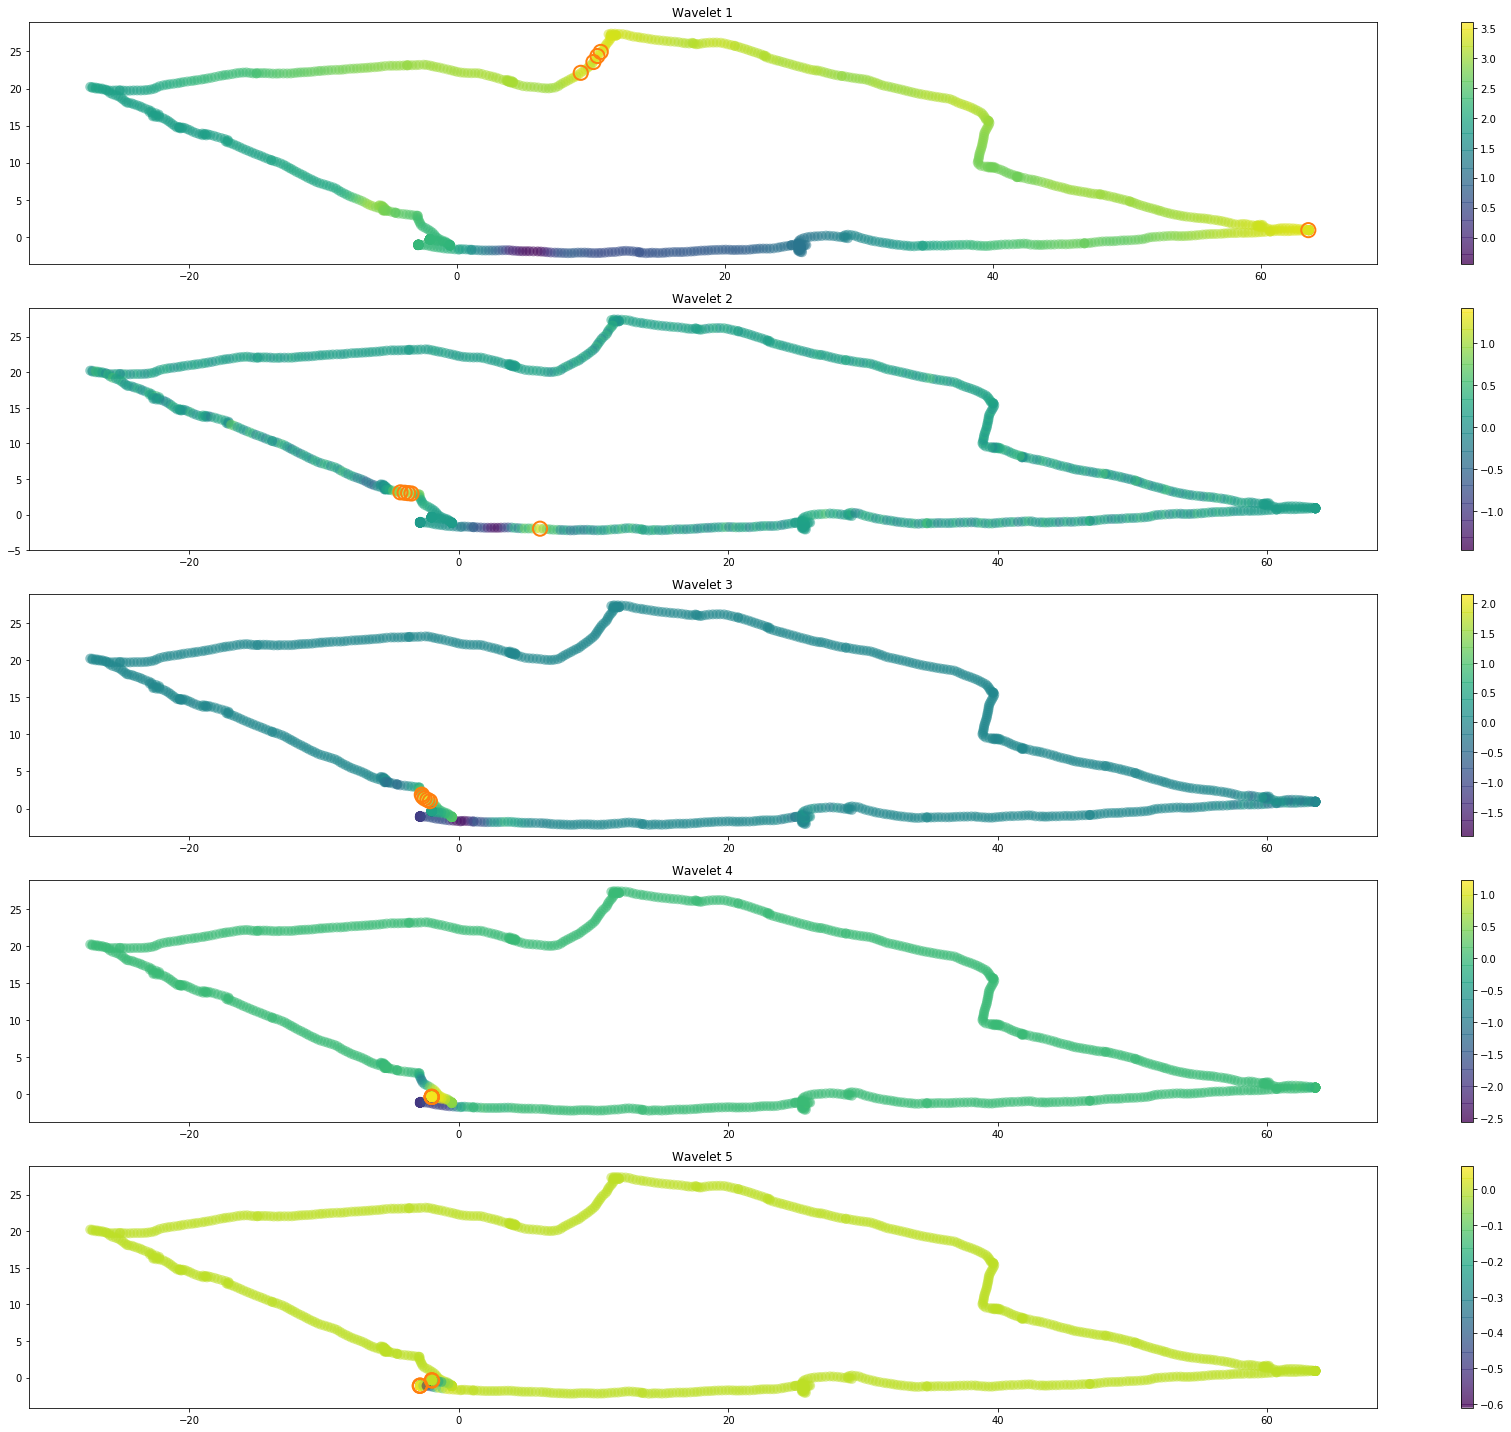

In [29]:
n_filter = 5

#g = filters.MexicanHat(G, Nf=n_filter)
g = filters.Meyer(G, Nf=n_filter)
s_rovio = g.filter(x_rovio)
s_loam = g.filter(x_loam)
s_opt = g.filter(x_opt)
#s_diff = g.filter(np.linalg.norm(x_diff, ord=2, axis=1))

s = np.zeros((s_opt.shape[0], n_filter))
#for i in range(0,n_filter):
#    s_diff = (s_rovio[:,i] - s_opt[:,i]).squeeze()   
#    s[:,i] = np.linalg.norm(s_diff, ord=2, axis=0)    

s = s_rovio - s_opt
fig, axes = plt.subplots(n_filter, 1, figsize=(24, 20))
fig.subplots_adjust(hspace=0.5)
for i in range(0, n_filter):    
    w = (np.divide(x_opt_hat, x_loam_hat/x_loam_hat))
    w = 1-(w - w.min()) / (w.max() - w.min())
    
    s_level = s[:,i]
    top_n = 5
    peaks = s_level.argsort()[-top_n:][::-1]
    #print(s_level[410])
    #peaks = np.zeros((1,top_n))
    #for j in range(0, top_n):     
     #   print(top_values[j])
      #  test = np.where(s_level == top_values[j])[0]
       # print(test)
        #peaks[0,j] = test
    
    s_tmp = s[:,i] * w
    #s_tmp = (s_tmp - s_tmp.min()) / (s_tmp.max() - s_tmp.min())
    _ = G.plot(s_tmp, title='Wavelet {}'.format(i+1), ax=axes[i], highlight=peaks)    
    #_ = G.plot(s[:, i], title='Wavelet {}'.format(i+1), ax=axes[i])    
fig.tight_layout()